In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=1ce0498bc28e4239e0fcc2c8565979f713f1f06cb6e6dafd83531ef06d30a1ad
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Using PyOD
from pyod.utils.data import generate_data, get_outliers_inliers
from pyod.models.pca import PCA
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [ ]:
df = pd.read_csv('/content/OpenStack_2k.log_structured.csv')

In [ ]:
df.head()

,LineId,Logrecord,Date,Time,Pid,Level,Component,ADDR,Content,EventId,EventTemplate
0,1,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:00.008,25746,INFO,nova.osapi_compute.wsgi.server,req-38101a0b-2096-447d-96ea-a692162415ae 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...",E25,"<*> ""GET <*>"" status: <*> len: <*> time: <*>.<*>"
1,2,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:00.272,25746,INFO,nova.osapi_compute.wsgi.server,req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...",E25,"<*> ""GET <*>"" status: <*> len: <*> time: <*>.<*>"
2,3,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:01.551,25746,INFO,nova.osapi_compute.wsgi.server,req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...",E25,"<*> ""GET <*>"" status: <*> len: <*> time: <*>.<*>"
3,4,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:01.813,25746,INFO,nova.osapi_compute.wsgi.server,req-2a3dc421-6604-42a7-9390-a18dc824d5d6 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...",E25,"<*> ""GET <*>"" status: <*> len: <*> time: <*>.<*>"
4,5,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:03.091,25746,INFO,nova.osapi_compute.wsgi.server,req-939eb332-c1c1-4e67-99b8-8695f8f1980a 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...",E25,"<*> ""GET <*>"" status: <*> len: <*> time: <*>.<*>"


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)

Training Data Shape: (1600, 11)
Testing Data Shape: (400, 11)


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LineId         2000 non-null   int64 
 1   Logrecord      2000 non-null   object
 2   Date           2000 non-null   object
 3   Time           2000 non-null   object
 4   Pid            2000 non-null   int64 
 5   Level          2000 non-null   object
 6   Component      2000 non-null   object
 7   ADDR           2000 non-null   object
 8   Content        2000 non-null   object
 9   EventId        2000 non-null   object
 10  EventTemplate  2000 non-null   object
dtypes: int64(2), object(9)
memory usage: 172.0+ KB
None


Remove columns that are irrelevant for clustering, such as LineId, Logrecord

In [ ]:
df = df.drop(columns=['LineId', 'Logrecord'])


Columns like Level, Component, and EventTemplate are categorical. Convert them into numeric form using LabelEncoder.

In [ ]:
encoder = LabelEncoder()

df['Level'] = encoder.fit_transform(df['Level'])
df['Component'] = encoder.fit_transform(df['Component'])
df['EventTemplate'] = encoder.fit_transform(df['EventTemplate'])


Combine Date and Time into a single datetime column, and optionally extract numerical features like hour, minute, or second.

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second

# Drop the original date, time, and timestamp columns
df = df.drop(columns=['Date', 'Time', 'Timestamp'])


Scale the data to standardize the ranges.

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)


ValueError: could not convert string to float: 'req-38101a0b-2096-447d-96ea-a692162415ae 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -'

In [ ]:
# Check the data types of each column
print(df.dtypes)

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Pid               int64
Level             int64
Component         int64
ADDR             object
Content          object
EventId          object
EventTemplate     int64
Hour              int32
Minute            int32
Second            int32
dtype: object
Non-numeric columns: Index(['ADDR', 'Content', 'EventId'], dtype='object')


In [ ]:
df = df.drop(columns=['EventId', 'ADDR', 'Content'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
for col in ['Level', 'Component', 'EventTemplate']:
    df[col] = LabelEncoder().fit_transform(df[col])


In [ ]:
print(df.head())
print(df.dtypes)


     Pid  Level  Component  EventTemplate  Hour  Minute  Second
0  25746      0          6              1     0       0       0
1  25746      0          6              1     0       0       0
2  25746      0          6              1     0       0       1
3  25746      0          6              1     0       0       1
4  25746      0          6              1     0       0       3
Pid              int64
Level            int64
Component        int64
EventTemplate    int64
Hour             int32
Minute           int32
Second           int32
dtype: object


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)


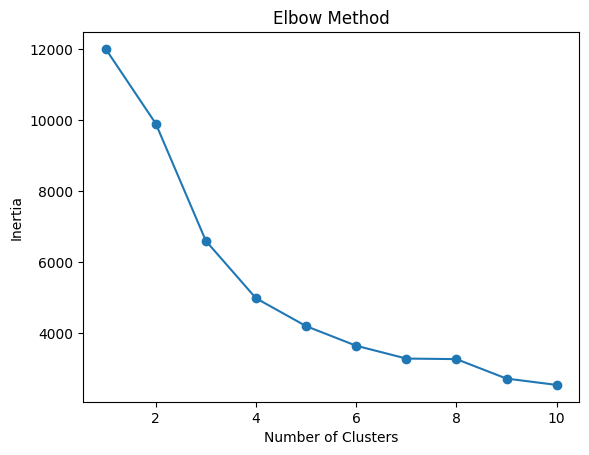

In [ ]:
# Elbow method to find the optimal number of clusters
inertia = []
k_range = range(1, 11)  # Try k=1 to k=10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [ ]:
# Apply K-Means with the chosen number of clusters (e.g., k=3)
optimal_k = 6  # Replace with the value from the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the original DataFrame
df['Cluster'] = kmeans.labels_

# View clustered data
print(df.head())


     Pid  Level  Component  EventTemplate  Hour  Minute  Second  Cluster
0  25746      0          6              1     0       0       0        4
1  25746      0          6              1     0       0       0        4
2  25746      0          6              1     0       0       1        4
3  25746      0          6              1     0       0       1        4
4  25746      0          6              1     0       0       3        4


In [ ]:
# Group by cluster and calculate mean for each column
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


                  Pid  Level  Component  EventTemplate  Hour     Minute  \
Cluster                                                                   
0         2931.000000    0.0   8.740920      24.283293   0.0   6.995157   
1        25585.000000    0.0   5.542500       1.427500   0.0  11.485000   
2         2931.000000    1.0   8.806452      16.032258   0.0   7.193548   
3         2931.000000    0.0   2.758836      28.249480   0.0   6.902287   
4        25412.291291    0.0   5.564565       1.450450   0.0   4.216216   
5        25754.444444    0.0   5.631579       1.409357   0.0   4.520468   

            Second  
Cluster             
0        27.876513  
1        26.635000  
2        28.290323  
3        28.486486  
4        13.138138  
5        47.111111  


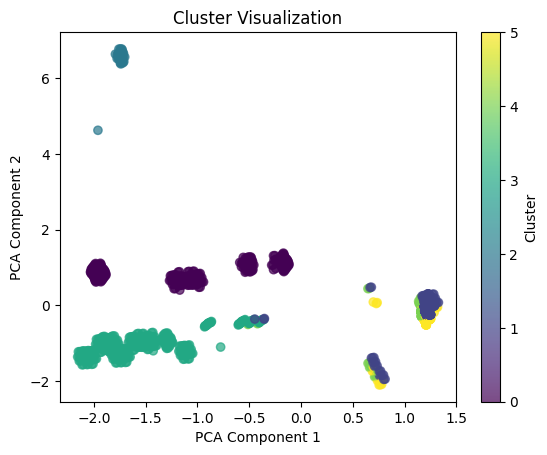

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Scatter plot of clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


The visualization shows the results of clustering applied to the log data, where:

Each dot represents a log entry that has been projected into a 2D space using PCA (Principal Component Analysis).
The colors represent the different clusters assigned by the clustering algorithm (e.g., K-Means).
The axes represent the first two principal components, which capture most of the variance in the data.

Key Insights:
Distinct Clusters:
The separation between clusters indicates that the log entries have been grouped based on similarities in their features.
For instance, the cluster in the top-left corner (light green/blue) suggests that these logs share unique characteristics distinct from others.
Overlapping Clusters:
Some clusters (e.g., purple and yellow) overlap slightly, suggesting that the features for these logs are not entirely distinct and might share similarities.
This could indicate either an inherent relationship between these logs or that the features might not fully capture their differences.
Potential Outliers:
The few isolated dots (e.g., at the top) might represent outliers or unusual log entries. These could be rare events, errors, or logs with unique characteristics.


In [ ]:
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


                  Pid  Level  Component  EventTemplate  Hour     Minute  \
Cluster                                                                   
0         2931.000000    0.0   8.740920      24.283293   0.0   6.995157   
1        25585.000000    0.0   5.542500       1.427500   0.0  11.485000   
2         2931.000000    1.0   8.806452      16.032258   0.0   7.193548   
3         2931.000000    0.0   2.758836      28.249480   0.0   6.902287   
4        25412.291291    0.0   5.564565       1.450450   0.0   4.216216   
5        25754.444444    0.0   5.631579       1.409357   0.0   4.520468   

            Second  
Cluster             
0        27.876513  
1        26.635000  
2        28.290323  
3        28.486486  
4        13.138138  
5        47.111111  


Logs far from cluster centroids or with low similarity to other points in their assigned cluster are likely anomalies.

In [ ]:
import numpy as np

# Compute the distance of each log to its cluster's centroid
distances = np.linalg.norm(scaled_data - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Define a threshold for anomalies (e.g., top 5% of distances)
threshold = np.percentile(distances, 95)
anomalies = df[distances > threshold]

# Add distance and anomaly labels to the DataFrame
df['Distance'] = distances
df['Anomaly'] = distances > threshold

print("Number of anomalies:", len(anomalies))
print(anomalies)


Number of anomalies: 100
        Pid  Level  Component  EventTemplate  Hour  Minute  Second  Cluster
6      2931      0          3             36     0       0       4        3
11     2931      0          9             41     0       0       5        0
12     2931      0          9             42     0       0       5        0
13     2931      0          9              3     0       0       5        0
20    25743      0          0              7     0       0      10        4
...     ...    ...        ...            ...   ...     ...     ...      ...
1966  25743      0          0              7     0      14      39        1
1978   2931      0          9              3     0      14      40        0
1981   2931      0          9             41     0      14      45        0
1982   2931      0          9             42     0      14      45        0
1985   2931      0          9              3     0      14      45        0

[100 rows x 8 columns]


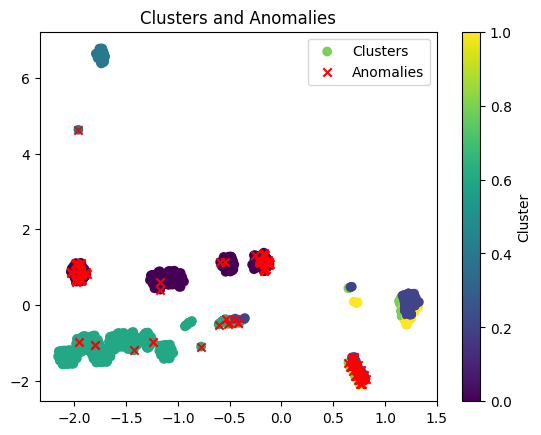

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot with anomalies highlighted
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', label='Clusters')
plt.scatter(reduced_data[distances > threshold, 0], reduced_data[distances > threshold, 1], c='red', label='Anomalies', marker='x')
plt.colorbar(label="Cluster")
plt.title("Clusters and Anomalies")
plt.legend()
plt.show()


DBSCAN identifies outliers naturally as points that don’t belong to any dense region (noise points).



In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(scaled_data)
df['DBSCAN_Cluster'] = dbscan.labels_

# Outliers are marked as -1 in DBSCAN
anomalies = df[df['DBSCAN_Cluster'] == -1]
print("Number of anomalies detected by DBSCAN:", len(anomalies))
print(anomalies)


Number of anomalies detected by DBSCAN: 166
        Pid  Level  Component  EventTemplate  Hour  Minute  Second  Cluster  \
20    25743      0          0              7     0       0      10        4   
56     2931      1          9             16     0       0      20        2   
57     2931      0          9             10     0       0      20        0   
58     2931      0          9             11     0       0      20        0   
59    25746      0          1              9     0       0      21        4   
...     ...    ...        ...            ...   ...     ...     ...      ...   
1924   2931      0          2             19     0      14      19        3   
1966  25743      0          0              7     0      14      39        1   
1978   2931      0          9              3     0      14      40        0   
1985   2931      0          9              3     0      14      45        0   
1998   2931      0          8             24     0      14      47        0   

      D

Isolation Forest is a tree-based anomaly detection algorithm that isolates anomalies more easily than inliers.

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Score'] = iso_forest.fit_predict(scaled_data)

# Anomalies are marked with -1
anomalies = df[df['Anomaly_Score'] == -1]
print("Number of anomalies detected by Isolation Forest:", len(anomalies))
print(anomalies)


Number of anomalies detected by Isolation Forest: 100
        Pid  Level  Component  EventTemplate  Hour  Minute  Second  Cluster  \
12     2931      0          9             42     0       0       5        0   
13     2931      0          9              3     0       0       5        0   
20    25743      0          0              7     0       0      10        4   
56     2931      1          9             16     0       0      20        2   
59    25746      0          1              9     0       0      21        4   
...     ...    ...        ...            ...   ...     ...     ...      ...   
1907  25746      0          1              9     0      14       9        1   
1909   2931      1          9             16     0      14      10        2   
1912   2931      1          9             16     0      14      15        2   
1923   2931      0          2             40     0      14      18        3   
1966  25743      0          0              7     0      14      39        1  

In [ ]:
print(anomalies[['Component']])


      Component
12            9
13            9
20            0
56            9
59            1
...         ...
1907          1
1909          9
1912          9
1923          2
1966          0

[100 rows x 1 columns]


In [ ]:
print(anomalies[['Level', 'Component', 'EventTemplate']].value_counts())


Level  Component  EventTemplate
1      9          16               30
0      0          7                22
       1          9                21
       9          42                7
       7          14                5
       9          41                4
       2          40                2
       7          13                2
       9          3                 2
       3          12                1
                  26                1
       8          24                1
                  25                1
1      3          17                1
Name: count, dtype: int64


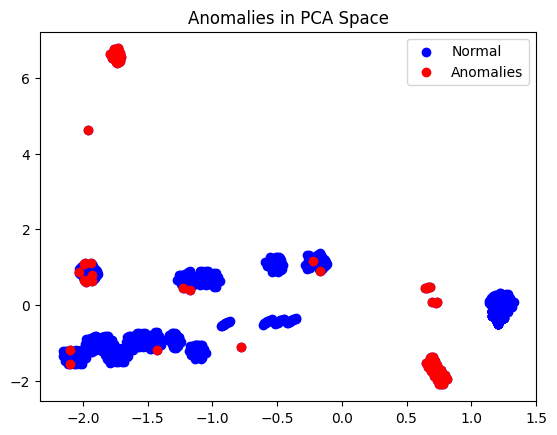

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot with anomalies highlighted
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', label='Normal')
plt.scatter(reduced_data[anomalies.index, 0], reduced_data[anomalies.index, 1], c='red', label='Anomalies')
plt.legend()
plt.title("Anomalies in PCA Space")
plt.show()
